<a href="https://colab.research.google.com/github/zyf2021/Cinnamon-Plant-Stem-and-Branch-Disease-Dataset/blob/main/Chapter_3_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d madhavipethangoda/cinnamon-plant-stem-and-branch-disease-dataset

 97% 645M/664M [00:07<00:00, 119MB/s]
100% 664M/664M [00:08<00:00, 86.9MB/s]


In [ ]:
! unzip /content/cinnamon-plant-stem-and-branch-disease-dataset.zip

Archive:  /content/cinnamon-plant-stem-and-branch-disease-dataset.zip
  inflating: Diseases/RoughBark/IMG_1563.JPG  
  inflating: Diseases/RoughBark/IMG_1564.JPG  
  inflating: Diseases/RoughBark/IMG_1668.JPG  
  inflating: Diseases/RoughBark/IMG_1887.JPG  
  inflating: Diseases/RoughBark/IMG_1944.JPG  
  inflating: Diseases/RoughBark/IMG_1964.JPG  
  inflating: Diseases/RoughBark/IMG_1965.JPG  
  inflating: Diseases/RoughBark/IMG_2010.JPG  
  inflating: Diseases/RoughBark/IMG_2044.JPG  
  inflating: Diseases/RoughBark/IMG_2058.JPG  
  inflating: Diseases/RoughBark/IMG_2098.JPG  
  inflating: Diseases/RoughBark/IMG_4780.JPG  
  inflating: Diseases/RoughBark/IMG_4782.JPG  
  inflating: Diseases/RoughBark/IMG_4783.JPG  
  inflating: Diseases/RoughBark/IMG_4784.JPG  
  inflating: Diseases/RoughBark/IMG_4785.JPG  
  inflating: Diseases/RoughBark/IMG_4786.JPG  
  inflating: Diseases/RoughBark/IMG_4787.JPG  
  inflating: Diseases/RoughBark/IMG_4788.JPG  
  inflating: Diseases/RoughBark/IMG_4

In [ ]:
import splitfolders
splitfolders.ratio('/content/Diseases', output="./", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 326 files [00:02, 137.38 files/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

In [ ]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),#слой субдисктретизации (пулинг)
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

определение модели со сверточными слоями через класс CNNNet()
это переопределение класса или что?

In [ ]:
cnnnet = CNNNet()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Функция обучения
По эпохам
На вход модель model - по которой обучаемся
train_loader, val_loader - обработанные кусочки датасета с batch, нормализацией и всей прочей фигней
device - устройство для расчета (процессор или видеокарта)
optimizer

---

[Ссылка на учебник ИТМО](https://neerc.ifmo.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D0%B0%D1%8F_%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0)
[Текст ссылки](https://vk.com/doc44301783_579615389?hash=hrHUm6WZfBPEYm6gEzF8y4CMjOJybMqCzET3OVA7THX)



In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    epoch_data= []
    training_loss_data = []
    valid_loss_data = []
    accuracy_data = []
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                               targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

        epoch_data.append(epoch)
        training_loss_data.append(training_loss)
        valid_loss_data.append(valid_loss)
        accuracy_data.append(num_correct / num_examples)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_title('Графики зависимостей', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Training Loss, Validation Loss, accuracy', fontsize=14)
        ax.grid(which='major', linewidth=1.2)
        ax.grid(which='minor', linestyle='--', color='gray', linewidth=0.5)
        
        ax.scatter(epoch_data, accuracy_data, c='red', label='accuracy')
        ax.plot(epoch_data, training_loss_data, c='yellow', label='Training Loss')
        ax.plot(epoch_data, valid_loss_data, c='green', label='Validation Loss')
        
        ax.legend()

        plt.show()

In [ ]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.001)

Epoch: 1, Training Loss: 0.31, Validation Loss: 0.37, accuracy = 0.86


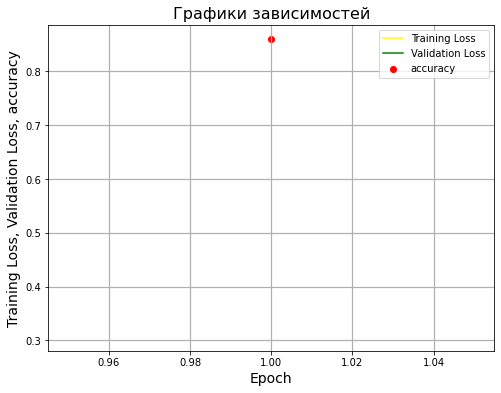

Epoch: 2, Training Loss: 0.31, Validation Loss: 0.63, accuracy = 0.81


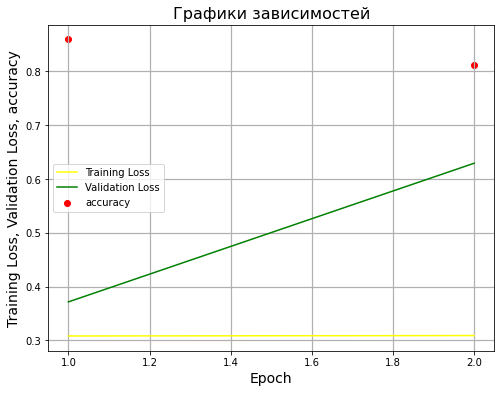

Epoch: 3, Training Loss: 0.36, Validation Loss: 0.33, accuracy = 0.86


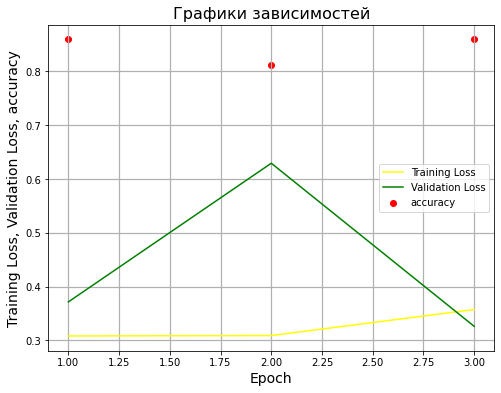

Epoch: 4, Training Loss: 0.26, Validation Loss: 0.28, accuracy = 0.91


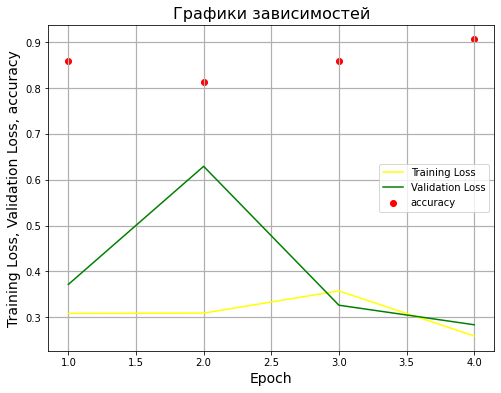

Epoch: 5, Training Loss: 0.20, Validation Loss: 0.37, accuracy = 0.86


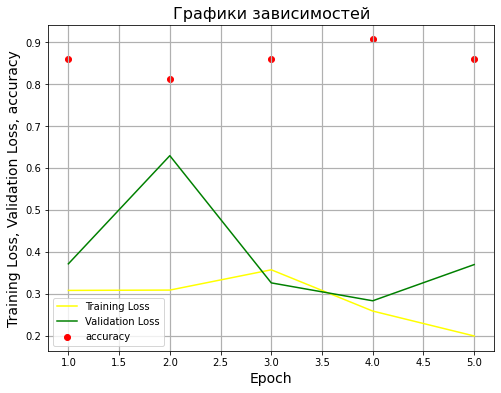

Epoch: 6, Training Loss: 0.16, Validation Loss: 0.40, accuracy = 0.88


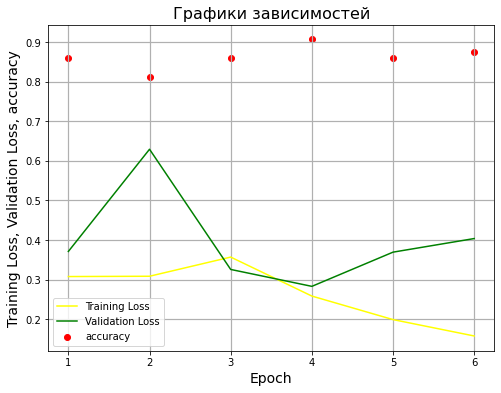

Epoch: 7, Training Loss: 0.13, Validation Loss: 0.75, accuracy = 0.80


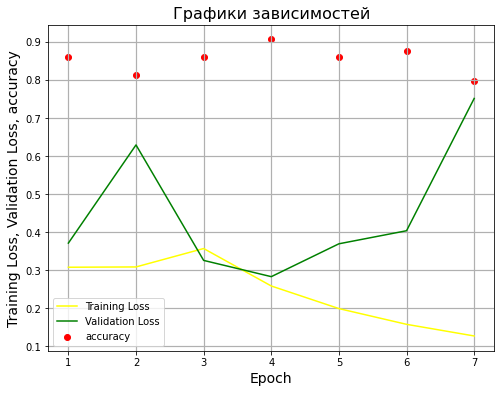

Epoch: 8, Training Loss: 0.21, Validation Loss: 0.39, accuracy = 0.88


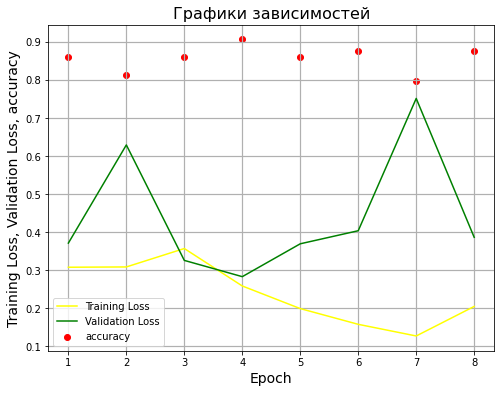

Epoch: 9, Training Loss: 0.12, Validation Loss: 0.32, accuracy = 0.91


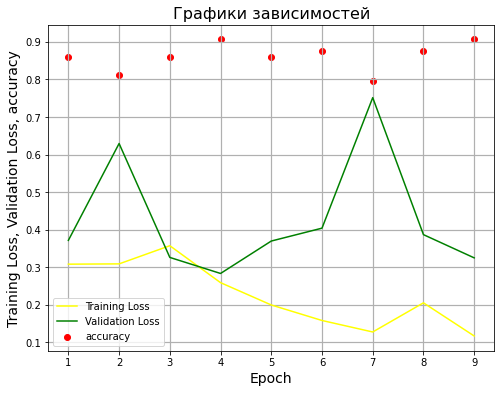

Epoch: 10, Training Loss: 0.06, Validation Loss: 0.91, accuracy = 0.84


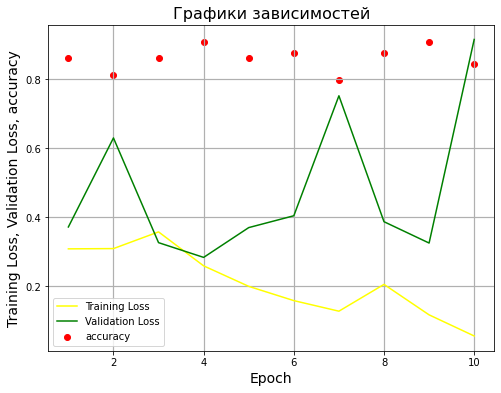

Epoch: 11, Training Loss: 0.11, Validation Loss: 0.46, accuracy = 0.89


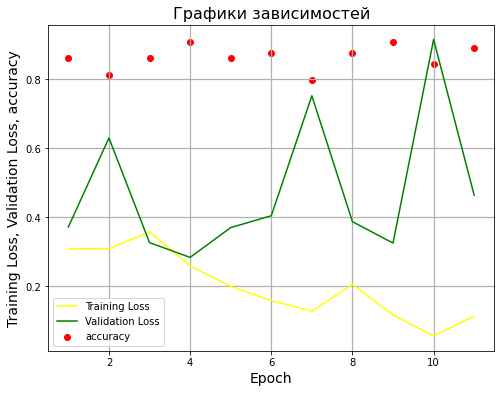

Epoch: 12, Training Loss: 0.06, Validation Loss: 0.50, accuracy = 0.84


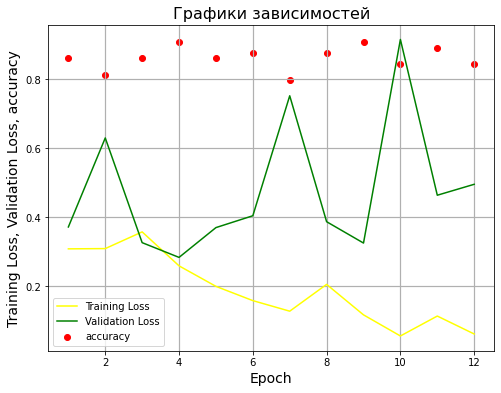

Epoch: 13, Training Loss: 0.15, Validation Loss: 0.86, accuracy = 0.81


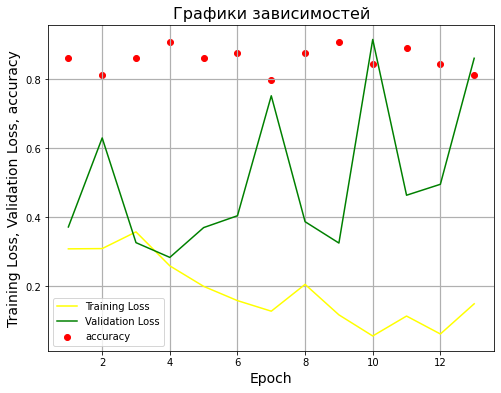

Epoch: 14, Training Loss: 0.11, Validation Loss: 0.47, accuracy = 0.86


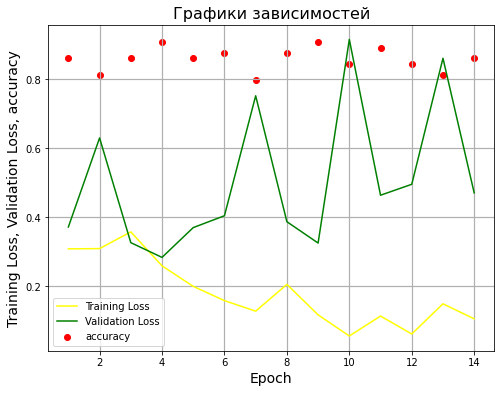

Epoch: 15, Training Loss: 0.09, Validation Loss: 0.50, accuracy = 0.81


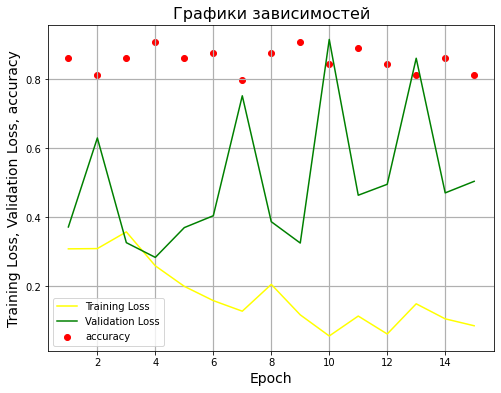

Epoch: 16, Training Loss: 0.07, Validation Loss: 0.40, accuracy = 0.84


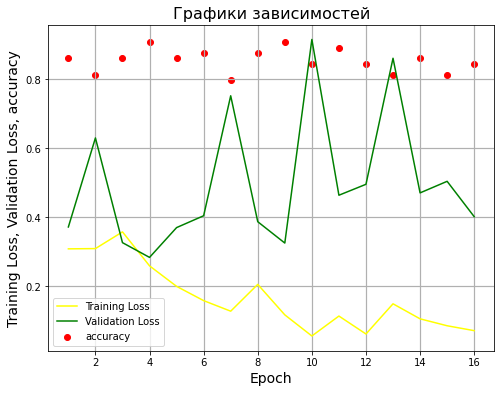

Epoch: 17, Training Loss: 0.03, Validation Loss: 0.53, accuracy = 0.86


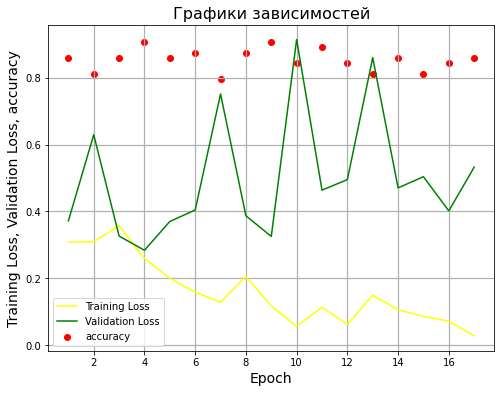

Epoch: 18, Training Loss: 0.02, Validation Loss: 0.80, accuracy = 0.86


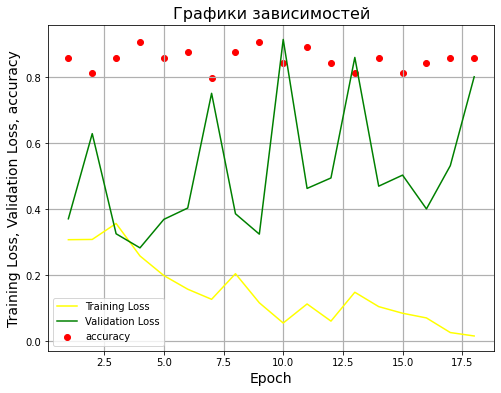

Epoch: 19, Training Loss: 0.00, Validation Loss: 1.02, accuracy = 0.88


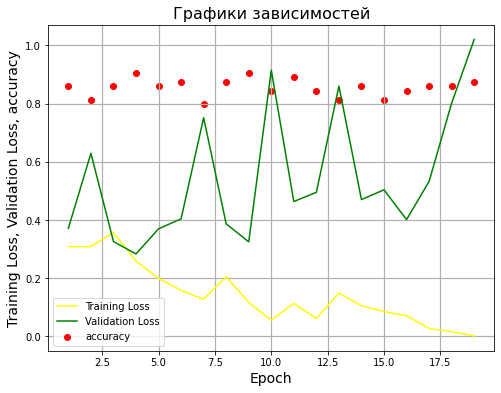

Epoch: 20, Training Loss: 0.00, Validation Loss: 1.31, accuracy = 0.86


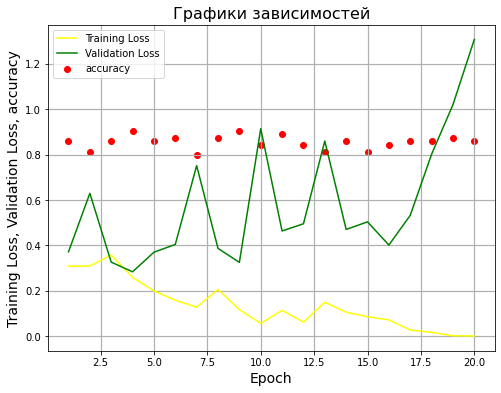

In [ ]:
train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

Epoch: 1, Training Loss: 1.06, Validation Loss: 0.96, accuracy = 0.48


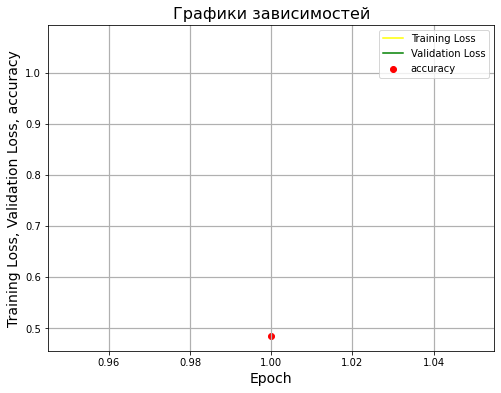

Epoch: 2, Training Loss: 0.83, Validation Loss: 0.72, accuracy = 0.48


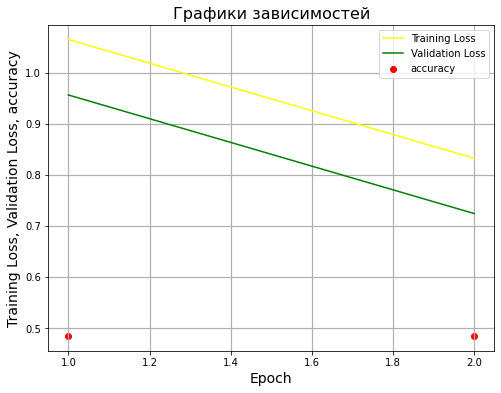

Epoch: 3, Training Loss: 0.70, Validation Loss: 0.69, accuracy = 0.64


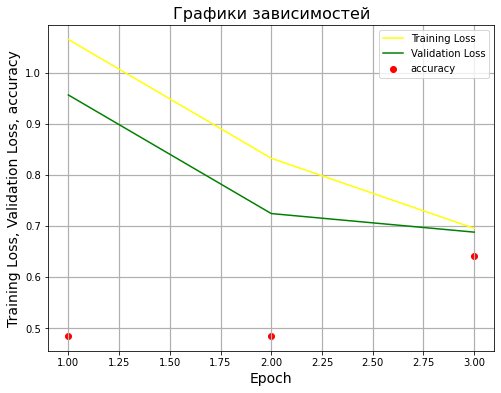

Epoch: 4, Training Loss: 0.68, Validation Loss: 0.68, accuracy = 0.48


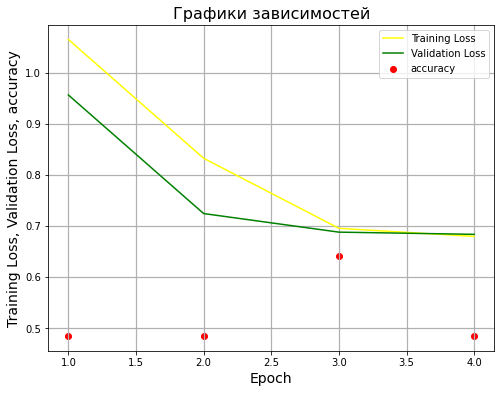

Epoch: 5, Training Loss: 0.66, Validation Loss: 0.60, accuracy = 0.78


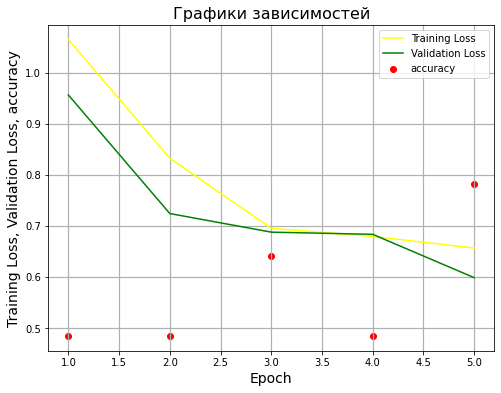

Epoch: 6, Training Loss: 0.60, Validation Loss: 0.61, accuracy = 0.67


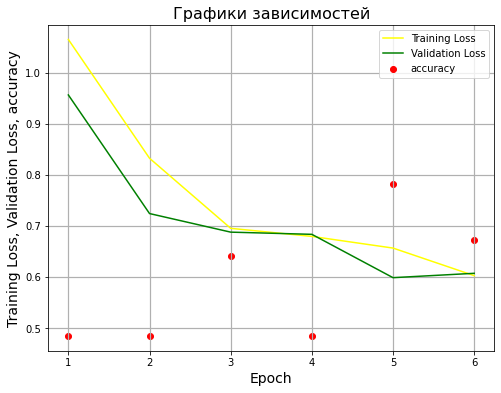

Epoch: 7, Training Loss: 0.53, Validation Loss: 0.54, accuracy = 0.78


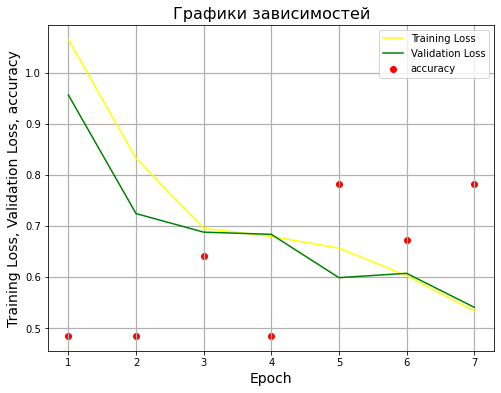

Epoch: 8, Training Loss: 0.43, Validation Loss: 0.39, accuracy = 0.88


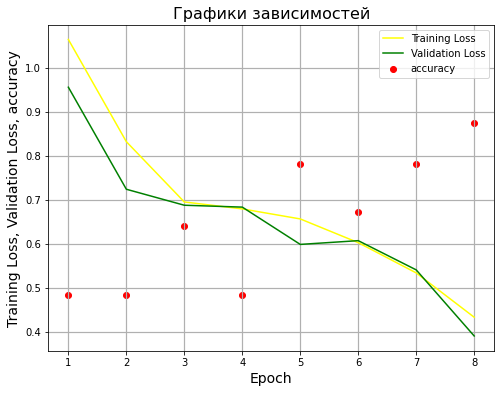

Epoch: 9, Training Loss: 0.39, Validation Loss: 0.47, accuracy = 0.81


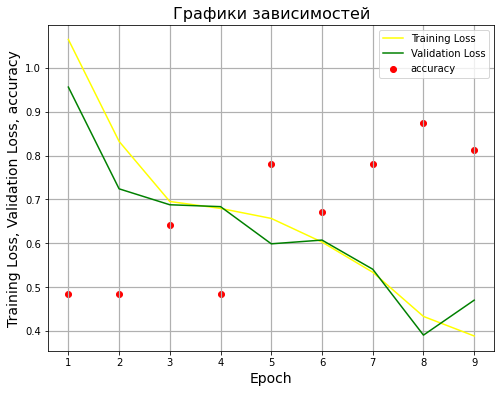

Epoch: 10, Training Loss: 0.38, Validation Loss: 0.38, accuracy = 0.78


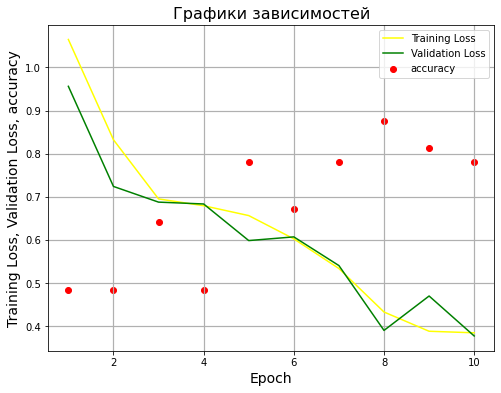

In [ ]:
train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=10, device=device)